# Use examples of [edges](https://github.com/romainsacchi/edges) for Mass Flow Analysis (MFA)

Author:  
Romain Sacchi, Researcher  
Laboratory for Energy Systems Analyses  
Paul Scherrer Institut (PSI)  
GitHub: [romainsacchi](https://github.com/romainsacchi)
Email: [romain.sacchi@psi.ch](mailto:romain.sacchi@psi.ch)

This notebook shows examples on how to use `edge` to use exchange-specific
characterization factors in the characterization matrix of `bw2calc`, in order
to derive in-use stock flows, which can be used for MFA.

## Requirements

* **Pyhton 3.10 or higher is recommended**
* **bw2data**
* **bw2calc**

# Use case with [Brightway](https://brightway.dev/)

`brightway2` is an open source LCA framework for Python.
Please refer to the brightway [documentation](https://brightway.dev) if you do not know how to create a project.

We start by importing the `EdgeLCIA` class.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import logging
import re
import pandas as pd
import numpy as np


from edges import EdgeLCIA, get_available_methods, setup_package_logging
import bw2data, bw2io

# logger setup
setup_package_logging(logging.INFO)

LCIA method files for `edges` can be json files, or simply a Python dictionary.
Let's consider the following LCIA method:

In [10]:
method = {
  "name": "Copper", #metadata
    "version": "1.0",
    "description": "Example LCIA method to track copper use",
    "unit": "kg Cu",
    "strategies": [ 
        "map_exchanges" # recommended strategies, can be later called by `EdgeLCIA.apply_strategies()`
    ],
  "exchanges": [
    {
      "supplier": { # selection criteria on the supplier side
        "name": "market for copper, cathode",
        "operator": "contains", # can be `equals`, `contains` or `startswith`
        "matrix": "technosphere", # nodes that belong to the technosphere matrix
          #we give a value of 1 to any supplier of copper
      },
      "consumer": {
        "matrix": "technosphere" # nodes that belong to the technosphere matrix
      },
      "value": 1.0 # CF value
    },
    {
    "supplier": {
        "name": "market for copper, anode",
        "operator": "contains",
        "matrix": "technosphere",
    },
    "consumer": {
        "matrix": "technosphere"
    },
    "value": 1.0
    },
  ]
}

In [11]:
# activate the bw project
bw2data.projects.set_current("ecoinvent-3.11-cutoff-bw25")
act = [a for a in bw2data.Database("ecoinvent-3.11-cutoff") if a["name"].startswith("distribution network")][0]
act

'distribution network construction, electricity, low voltage' (kilometer, RoW, None)

In [12]:
# EdgeLCIA class instantiation
LCA = EdgeLCIA(
    demand={act: 1}, # functional unit
    method=method, # method defined above
)
LCA.lci()

LCA.apply_strategies() # either run `.apply_strategies()`
#LCA.map_exchanges() # or run mapping strategies manually

LCA.evaluate_cfs() # fill-in the characterization matrix
LCA.lcia() # calculates score
LCA.score # print score

Mapping exchanges: 100%|██████████| 2/2 [00:00<00:00, 110.88it/s]


7640.6983792427545

We can generate a pandas.Dataframe that lists characterized exchanges

In [13]:
df = LCA.generate_cf_table(include_unmatched=False)

In [14]:
df.sort_values(by="impact", ascending=False)

,supplier name,supplier reference product,supplier location,supplier cpc,supplier ecospold01categories,supplier isic rev.4 ecoinvent,consumer name,consumer reference product,consumer location,consumer cpc,consumer ecospold01categories,consumer isic rev.4 ecoinvent,amount,CF,impact
398,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"distribution network construction, electricity...","distribution network, electricity, low voltage",RoW,53252: Local cables and related works,electricity/distribution,4220:Construction of utility projects,4.600131e+03,1.0,4.600131e+03
599,"market for copper, anode","copper, anode",GLO,41412: Unrefined copper; copper anodes for ele...,None,2420:Manufacture of basic precious and other n...,"electrorefining of copper, anode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",None,2420:Manufacture of basic precious and other n...,2.832248e+03,1.0,2.832248e+03
598,"market for copper, anode","copper, anode",GLO,41412: Unrefined copper; copper anodes for ele...,None,2420:Manufacture of basic precious and other n...,treatment of copper scrap by electrolytic refi...,"copper, cathode",RoW,"41413: Refined copper and copper alloys, unwro...",None,2420:Manufacture of basic precious and other n...,8.070573e+01,1.0,8.070573e+01
129,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"building construction, multi-storey","building, multi-storey",RER,5312: Non-residential buildings,construction processes/buildings,4100:Construction of buildings,6.057044e+01,1.0,6.057044e+01
394,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"building construction, multi-storey","building, multi-storey",RoW,5312: Non-residential buildings,construction processes/buildings,4100:Construction of buildings,3.185378e+01,1.0,3.185378e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"magnesium-alloy production, AZ91","magnesium-alloy, AZ91",RoW,"41601: Tungsten, molybdenum, tantalum, magnesi...",metals/extraction,2420:Manufacture of basic precious and other n...,-1.190276e-22,1.0,-1.190276e-22
29,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"plug production, inlet and outlet, for printer...","plug, inlet and outlet, for printer cable",GLO,45290: Parts and accessories of computing mach...,electronics/component,2610:Manufacture of electronic components and ...,-3.118753e-21,1.0,-3.118753e-21
307,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"cable production, printer cable, without plugs","cable, printer cable, without plugs",GLO,45290: Parts and accessories of computing mach...,electronics/component,2610:Manufacture of electronic components and ...,-4.758037e-20,1.0,-4.758037e-20
332,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"printer production, laser, black/white","printer, laser, black/white",GLO,45264: Laser printers used with data processin...,electronics/devices,2620:Manufacture of computers and peripheral e...,-3.625426e-19,1.0,-3.625426e-19


We've built a small mapping between CPC codes a lifetimes (in years).

In [15]:
lifetimes = pd.read_csv("cpc_with_lifetimes.csv")
lifetimes.head()

,CPC classification,lifetime_years_refined
0,34160: Organo-sulphur compounds and other orga...,1
1,"3462: Mineral or chemical fertilizers, phosphatic",1
2,"34210: Hydrogen, nitrogen, oxygen, carbon diox...",1
3,34232: Phosphoric acid,1
4,02111: Cattle,5


Let's see how lifetimes distribute across CPC codes.

<Axes: ylabel='Frequency'>

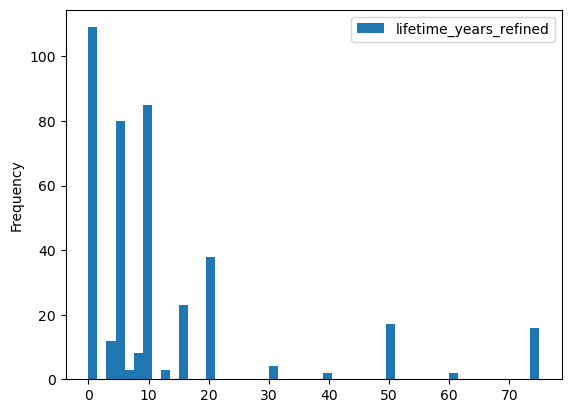

In [16]:
lifetimes.plot(kind="hist", bins=50)

Let's try to map those with the exchanges in the dataframe, based on the consumer's CPC code.

In [17]:
# Extract numeric CPC codes
lifetimes["cpc_code"] = lifetimes["CPC classification"].str.extract(r"^\s*(\d+)")
df["consumer cpc code"] = df["consumer cpc"].str.extract(r"^\s*(\d+)")

# Create mapping dict
code_to_lifetime = lifetimes.set_index("cpc_code")["lifetime_years_refined"]

# Map lifetimes to consumer CPCs
df["lifetime"] = df["consumer cpc code"].map(code_to_lifetime)

In [18]:
df

,supplier name,supplier reference product,supplier location,supplier cpc,supplier ecospold01categories,supplier isic rev.4 ecoinvent,consumer name,consumer reference product,consumer location,consumer cpc,consumer ecospold01categories,consumer isic rev.4 ecoinvent,amount,CF,impact,consumer cpc code,lifetime
0,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"greenhouse construction, plastic walls and roo...","greenhouse, plastic walls and roof",RoW,"38703: Prefabricated buildings, of plastics",None,4100:Construction of buildings,9.657156e-09,1.0,9.657156e-09,38703,10
1,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"inductor production, ring core choke type","inductor, ring core choke type",GLO,47173: Parts for the goods of subclasses 47140...,electronics/component,2610:Manufacture of electronic components and ...,6.432769e-03,1.0,6.432769e-03,47173,8
2,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,"treatment of leachate, SLF, municipal solid wa...","leachate, SLF, municipal solid waste",HU,39990: Other wastes n.e.c.,None,3700:Sewerage,1.118365e-10,1.0,1.118365e-10,39990,0
3,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,treatment of wastewater from black chrome coat...,wastewater from black chrome coating,CH,39990: Other wastes n.e.c.,None,3700:Sewerage,6.165820e-13,1.0,6.165820e-13,39990,0
4,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,ethanol fermentation plant construction,ethanol fermentation plant,CH,53269: Other constructions for manufacturing,biomass/fuels,4290:Construction of other civil engineering p...,4.653680e-12,1.0,4.653680e-12,53269,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,"market for copper, cathode","copper, cathode",GLO,"41413: Refined copper and copper alloys, unwro...",metals/extraction,2420:Manufacture of basic precious and other n...,treatment of wastewater from liquid crystal di...,wastewater from liquid crystal display backlig...,CH,39990: Other wastes n.e.c.,None,3700:Sewerage,5.793719e-15,1.0,5.793719e-15,39990,0
596,"market for copper, anode","copper, anode",GLO,41412: Unrefined copper; copper anodes for ele...,None,2420:Manufacture of basic precious and other n...,treatment of copper scrap by electrolytic refi...,"copper, cathode",RER,"41413: Refined copper and copper alloys, unwro...",None,2420:Manufacture of basic precious and other n...,1.827976e+01,1.0,1.827976e+01,41413,10
597,"market for copper, anode","copper, anode",GLO,41412: Unrefined copper; copper anodes for ele...,None,2420:Manufacture of basic precious and other n...,"electrorefining of copper, anode","anode slime from electrorefining of copper, anode",GLO,"14210: Copper, ores and concentrates",None,2420:Manufacture of basic precious and other n...,4.943355e-03,1.0,4.943355e-03,14210,10
598,"market for copper, anode","copper, anode",GLO,41412: Unrefined copper; copper anodes for ele...,None,2420:Manufacture of basic precious and other n...,treatment of copper scrap by electrolytic refi...,"copper, cathode",RoW,"41413: Refined copper and copper alloys, unwro...",None,2420:Manufacture of basic precious and other n...,8.070573e+01,1.0,8.070573e+01,41413,10


# Use case with sales of passenger cars
We will use a scenario from an Integrated Assessment Model (IAM).  
The scenario is from the [REMIND](https://www.pik-potsdam.de/en/institute/departments/transformation-pathways/models/remind) model: SSP1 - Peak CO2 budget of 650 gigatons i.e., aligns with a global mean surface temperature increase of +1.5 C by 2100).  
The data describe the sales of new passenger cars in Europe, in millions of vehicles.

In [23]:
sales = pd.read_excel("vehicle_sales.xlsx")

In [24]:
sales

,Model,Scenario,Region,Variable,Unit,2005,2010,2015,2020,2025,...,2050,2055,2060,2070,2080,2090,2100,2110,2130,2150
0,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|BEV,million veh,0.030950,0.030282,0.088200,0.308644,1.717077,...,7.236458,8.740421,7.820661,7.489430,6.189928,6.013639,4.490665,4.490665,4.490665,4.490665
1,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|FCEV,million veh,0.023272,0.022834,0.025781,0.023492,0.086555,...,0.017698,0.020342,0.017456,0.015653,0.012141,0.010987,0.007475,0.007475,0.007475,0.007475
2,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|Gases,million veh,0.026202,0.024879,0.019500,0.012021,0.043927,...,0.000255,0.000293,0.000247,0.000217,0.000166,0.000146,0.000097,0.000097,0.000097,0.000097
3,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|Hy...,million veh,0.150389,0.157100,0.311240,0.531024,2.026875,...,0.000511,0.000594,0.000506,0.000448,0.000343,0.000305,0.000206,0.000206,0.000206,0.000206
4,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|Li...,million veh,12.987550,13.423850,15.998178,13.934007,8.947001,...,0.000629,0.000730,0.000619,0.000544,0.000413,0.000362,0.000242,0.000242,0.000242,0.000242


In [25]:
import re
import pandas as pd
import numpy as np


year_cols = []
for c in sales.columns:
    if isinstance(c, int):
        year_cols.append(c)
sales[year_cols] = sales[year_cols].apply(pd.to_numeric, errors="coerce")

years_sorted = sorted(year_cols, key=int)
all_years = [y for y in range(int(years_sorted[0]), int(years_sorted[-1]) + 1)]

year_block = (
    sales.set_index(id_cols)[year_cols]         # keep only year data
         .reindex(columns=all_years)            # add missing years as NaN
         .interpolate(axis=1, limit_direction="both")  # linear fill
)

sales = (
    year_block
    .reset_index()
    .merge(sales[id_cols].drop_duplicates(), on=id_cols, how="left")
)

NameError: name 'id_cols' is not defined

In [26]:
sales

,Model,Scenario,Region,Variable,Unit,2005,2010,2015,2020,2025,...,2050,2055,2060,2070,2080,2090,2100,2110,2130,2150
0,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|BEV,million veh,0.030950,0.030282,0.088200,0.308644,1.717077,...,7.236458,8.740421,7.820661,7.489430,6.189928,6.013639,4.490665,4.490665,4.490665,4.490665
1,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|FCEV,million veh,0.023272,0.022834,0.025781,0.023492,0.086555,...,0.017698,0.020342,0.017456,0.015653,0.012141,0.010987,0.007475,0.007475,0.007475,0.007475
2,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|Gases,million veh,0.026202,0.024879,0.019500,0.012021,0.043927,...,0.000255,0.000293,0.000247,0.000217,0.000166,0.000146,0.000097,0.000097,0.000097,0.000097
3,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|Hy...,million veh,0.150389,0.157100,0.311240,0.531024,2.026875,...,0.000511,0.000594,0.000506,0.000448,0.000343,0.000305,0.000206,0.000206,0.000206,0.000206
4,REMIND,SSP1-PkBudg650,EUR,Sales|Transport|Pass|Road|LDV|Four Wheelers|Li...,million veh,12.987550,13.423850,15.998178,13.934007,8.947001,...,0.000629,0.000730,0.000619,0.000544,0.000413,0.000362,0.000242,0.000242,0.000242,0.000242


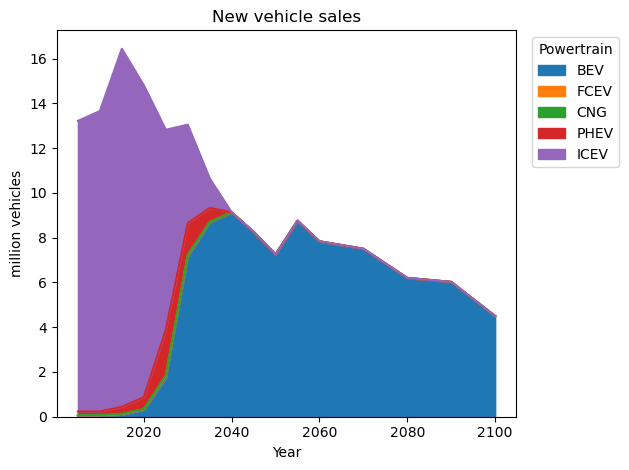

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

df = sales.copy()
df = df.loc[:, :2100]

# years are the numeric columns
years = [c for c in df.columns if isinstance(c, (int, float))]

# extract powertrain from the end of the pipe-delimited Variable
df["Powertrain"] = df["Variable"].str.extract(r'([^|]+)$')

# normalize names to your legend labels
name_map = {
    "Gases": "CNG",
    "Hybrid electric": "PHEV",
    "Liquids": "ICEV",
    "BEV": "BEV",
    "FCEV": "FCEV",
}
df["Powertrain"] = df["Powertrain"].replace(name_map)

# long → wide: index=Year, columns=Powertrain
wide = (
    df.melt(id_vars="Powertrain", value_vars=years,
            var_name="Year", value_name="Sales")
      .pivot_table(index="Year", columns="Powertrain",
                   values="Sales", aggfunc="sum")
      .sort_index()
)

# optional: enforce legend/stack order
order = ["BEV", "FCEV", "CNG", "PHEV", "ICEV"]
wide = wide[[c for c in order if c in wide.columns]]

ax = wide.plot(kind="area")
ax.set_title("New vehicle sales")
ax.set_ylabel("million vehicles")
ax.legend(title="Powertrain", loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()


Now, let's import in brightway, using `bw2io`, some life cycle inventories that represent the manufacture of passenger cars.

In [28]:
i = bw2io.ExcelImporter("lci-pass_cars.xlsx")

Extracted 1 worksheets in 0.09 seconds


In [29]:
i.apply_strategies()

Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.30 seconds


We link the imported inventories against themselves, the ecoinvent database and the biosphere database (in that order).

In [30]:
i.match_database(fields=["name", "reference product", "location"])
i.match_database("ecoinvent-3.11-cutoff", fields=["name", "reference product", "location"])
i.match_database("ecoinvent-3.11-biosphere", fields=["name", "categories"])

Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Zero unlinked exchanges, we can go ahead!

In [31]:
i.statistics()

Graph statistics for `lci-pass_cars` importer:
218 graph nodes:
	process: 206
	None: 12
2139 graph edges:
	technosphere: 1912
	production: 218
	biosphere: 9
2139 edges to the following databases:
	ecoinvent-3.11-cutoff: 1650
	lci-pass_cars: 480
	ecoinvent-3.11-biosphere: 9
0 unique unlinked edges (0 total):




(218, 2139, 0, 0)

In [32]:
i.write_database()

14:13:38+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 218/218 [00:00<00:00, 2276.91it/s]

14:13:38+0100 [info     ] Vacuuming database            


Created database: lci-pass_cars


We create shorcuts/references to the dataset objects representing the building of a car from our newly imported database

In [33]:
icev = [ds for ds in bw2data.Database("lci-pass_cars") if ds["name"] == "Passenger car, gasoline, Medium, EURO-6d"][0]
bev = [ds for ds in bw2data.Database("lci-pass_cars") if ds["name"] == "Passenger car, battery electric, Medium"][0]
cng = [ds for ds in bw2data.Database("lci-pass_cars") if ds["name"] == "Passenger car, compressed gas, Medium, EURO-6d"][0]
hybrid = [ds for ds in bw2data.Database("lci-pass_cars") if ds["name"] == "Passenger car, plugin gasoline hybrid, Medium, EURO-6d"][0]
fcev = [ds for ds in bw2data.Database("lci-pass_cars") if ds["name"] == "Passenger car, fuel cell electric, Medium"][0]

In [34]:
# convert from millions of vehicles to vehicles
wide *= 1e6

In [35]:
wide

Powertrain,BEV,FCEV,CNG,PHEV,ICEV
Year,,,,,
2005,3.094969e+04,23272.040548,26202.337863,1.503888e+05,1.298755e+07
2010,3.028207e+04,22834.380912,24878.505323,1.571002e+05,1.342385e+07
2015,8.820027e+04,25780.684428,19499.611180,3.112400e+05,1.599818e+07
2020,3.086445e+05,23491.727893,12021.396902,5.310236e+05,1.393401e+07
2025,1.717077e+06,86555.270357,43927.388046,2.026875e+06,8.947001e+06
2030,7.148352e+06,62752.720648,29838.262312,1.410487e+06,4.398287e+06
2035,8.671269e+06,29202.498787,13144.642040,6.171917e+05,1.319161e+06
2040,9.107672e+06,25597.685530,365.258040,7.265727e+02,8.988708e+02
2045,8.245147e+06,21662.328497,306.419044,6.094050e+02,7.497714e+02


In [36]:
# create a dictionary to store the results per vehicle type
per_vehicle = {}

for fu, tech in [
    ({icev.id: 1.0},   "ICEV"),
    ({bev.id: 1.0},    "BEV"),
    ({cng.id: 1.0},    "CNG"),
    ({hybrid.id: 1.0}, "PHEV"),
    ({fcev.id: 1.0},   "FCEV"),
]:
    if tech == "ICEV":
        LCA = EdgeLCIA(demand=fu, method=method)
        LCA.lci()
        LCA.apply_strategies()
        LCA.evaluate_cfs()
        LCA.lcia()
    else:
        LCA.redo_lcia(fu)

    df = LCA.generate_cf_table().copy()

    # Extract CPC code and map lifetime
    if "consumer cpc code" not in df.columns and "consumer cpc" in df.columns:
        df["consumer cpc code"] = df["consumer cpc"].str.extract(r"^\s*(\d+)")
    df["lifetime"] = df["consumer cpc code"].map(code_to_lifetime)

    # Optional: one dataset does not have a CPC code
    df.loc[df["consumer name"] == "Glider lightweighting", "lifetime"] = 12

    per_vehicle[tech] = df[["amount", "lifetime"]].copy()  # keep only what we need


wide = wide.sort_index()

yearly_frames = []
for tech, exch in per_vehicle.items():
    # sales series for this tech
    if tech not in wide.columns:
        continue
    sales = wide[[tech]].reset_index().rename(columns={tech: "vehicles"})  # columns: Year, vehicles

    # cross-join: add a constant key
    exch_ = exch.copy()
    exch_["key"] = 1
    sales["key"] = 1
    merged = exch_.merge(sales, on="key", how="left").drop(columns="key")

    # inflow per exchange-year
    merged["tech"] = tech
    merged["total_amount"] = merged["amount"] * merged["vehicles"]

    yearly_frames.append(merged)

df_yearly_exchanges = pd.concat(yearly_frames, ignore_index=True)

df_yearly_exchanges["Year"] = df_yearly_exchanges["Year"].astype(int)
df_yearly_exchanges["lifetime"] = df_yearly_exchanges["lifetime"].fillna(0).astype(int)

# Year when copper returns
df_yearly_exchanges["return_year"] = df_yearly_exchanges["Year"] + df_yearly_exchanges["lifetime"]

# Outflow (returns)
copper_returns = (
    df_yearly_exchanges.groupby("return_year", as_index=False)["total_amount"]
    .sum()
    .rename(columns={"return_year": "Year", "total_amount": "copper_return"})
)

# Inflow (sales)
copper_sales = (
    df_yearly_exchanges.groupby("Year", as_index=False)["total_amount"]
    .sum()
    .rename(columns={"total_amount": "copper_sales"})
)

# Merge and compute stock
copper_stock_flow = pd.merge(copper_sales, copper_returns, on="Year", how="outer").fillna(0.0)
copper_stock_flow = copper_stock_flow.sort_values("Year")
copper_stock_flow["stock_in_use"] = (
    copper_stock_flow["copper_sales"].cumsum() - copper_stock_flow["copper_return"].cumsum()
)

Mapping exchanges: 100%|██████████| 2/2 [00:00<00:00, 9414.82it/s]


In [37]:
# here is our dataframe with summed (across powertrain types) in-use, incoming and outgoing copper flows per year.
copper_stock_flow

,Year,copper_sales,copper_return,stock_in_use
0,2005,5.070541e+08,1.768250e+06,5.052858e+08
1,2006,0.000000e+00,2.284711e+05,5.050573e+08
2,2008,0.000000e+00,4.908658e-01,5.050573e+08
3,2010,5.235773e+08,2.770948e+06,1.025864e+09
4,2011,0.000000e+00,2.354287e+05,1.025628e+09
...,...,...,...,...
88,2150,0.000000e+00,9.136280e+04,6.153948e+07
89,2155,0.000000e+00,2.281363e+07,3.872585e+07
90,2160,0.000000e+00,6.818397e+04,3.865766e+07
91,2165,0.000000e+00,2.214234e+07,1.651532e+07


In [38]:
# convert to ktons
copper_stock_flow.loc[:, "copper_sales":] /= 1e6

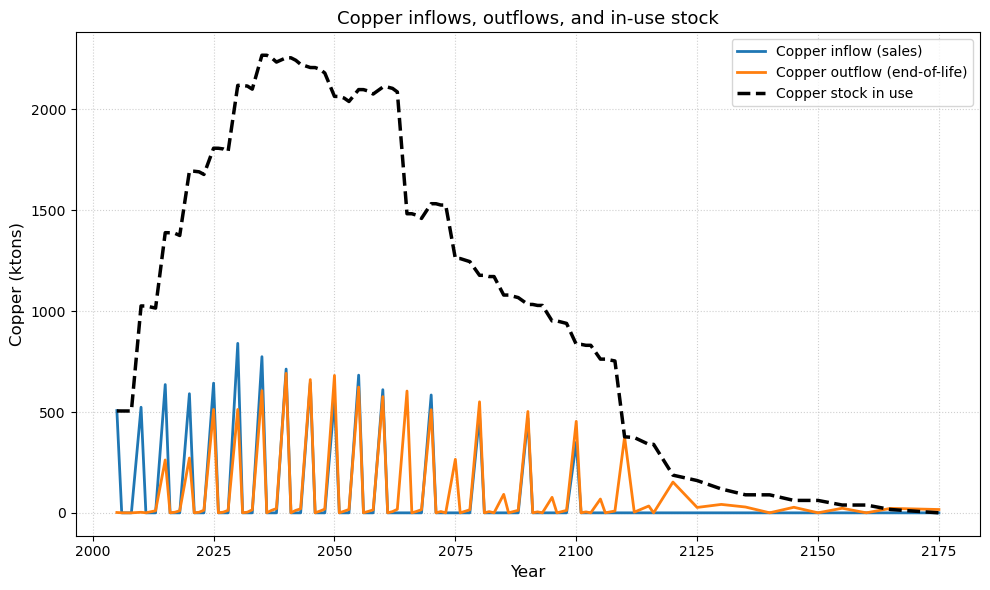

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(
    copper_stock_flow["Year"],
    copper_stock_flow["copper_sales"],
    label="Copper inflow (sales)",
    color="#1f77b4",
    linewidth=2,
)
plt.plot(
    copper_stock_flow["Year"],
    copper_stock_flow["copper_return"],
    label="Copper outflow (end-of-life)",
    color="#ff7f0e",
    linewidth=2,
)
plt.plot(
    copper_stock_flow["Year"],
    copper_stock_flow["stock_in_use"],
    label="Copper stock in use",
    color="black",
    linewidth=2.5,
    linestyle="--",
)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Copper (ktons)", fontsize=12)
#plt.yscale('log')
plt.title("Copper inflows, outflows, and in-use stock", fontsize=13)
plt.legend(title="", loc="upper right")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


By looking at the logarithmic scale, we can see copper coming back before the first discarded cars.  
Also, we can see copper coming back long after the last discarded cars.  
What are those?


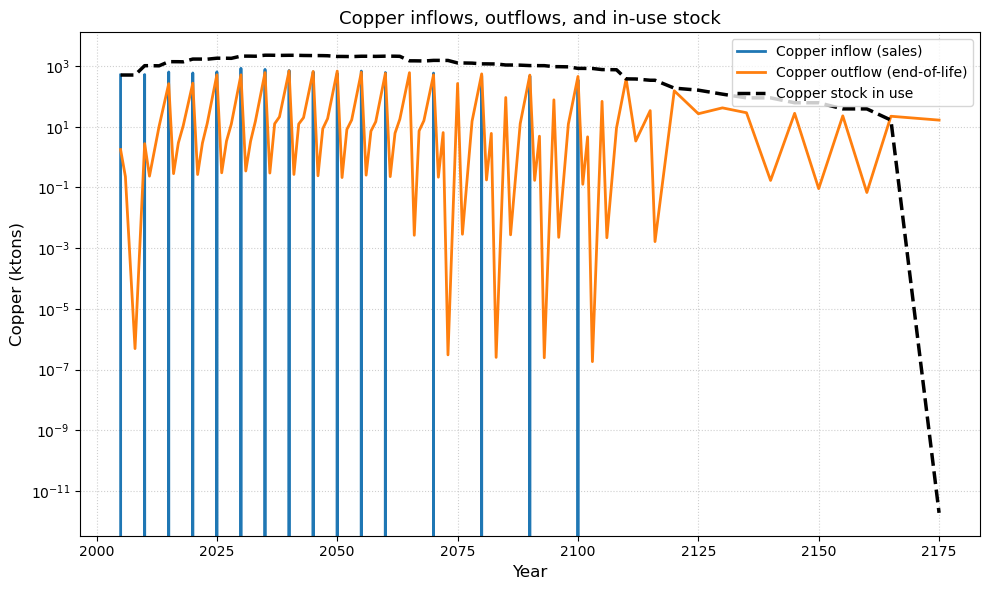

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(
    copper_stock_flow["Year"],
    copper_stock_flow["copper_sales"],
    label="Copper inflow (sales)",
    color="#1f77b4",
    linewidth=2,
)
plt.plot(
    copper_stock_flow["Year"],
    copper_stock_flow["copper_return"],
    label="Copper outflow (end-of-life)",
    color="#ff7f0e",
    linewidth=2,
)
plt.plot(
    copper_stock_flow["Year"],
    copper_stock_flow["stock_in_use"],
    label="Copper stock in use",
    color="black",
    linewidth=2.5,
    linestyle="--",
)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Copper (ktons)", fontsize=12)
plt.yscale('log')
plt.title("Copper inflows, outflows, and in-use stock", fontsize=13)
plt.legend(title="", loc="upper right")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


Let's try with other metals!

In [46]:
copper_method = {
  "name": "Copper",
    "version": "1.0",
    "description": "Example LCIA method to track copper use",
    "unit": "kg Cu",
    "strategies": [
        "map_exchanges"
    ],
  "exchanges": [
    {
      "supplier": {
        "name": "market for copper, cathode",
        "operator": "contains",
        "matrix": "technosphere",
      },
      "consumer": {
        "matrix": "technosphere"
      },
      "value": 1.0
    },
    {
    "supplier": {
        "name": "market for copper, anode",
        "operator": "contains",
        "matrix": "technosphere",
    },
    "consumer": {
        "matrix": "technosphere"
    },
    "value": 1.0
    },
  ]
}

aluminium_method = {
  "name": "Aluminium",
    "version": "1.0",
    "description": "Example LCIA method to track aluminium use",
    "unit": "kg Cu",
    "strategies": [
        "map_exchanges"
    ],
  "exchanges": [
    {
      "supplier": {
        "name": "market for aluminium alloy",
        "operator": "contains",
        "matrix": "technosphere",
      },
      "consumer": {
        "matrix": "technosphere"
      },
      "value": 1.0
    },
  ]
}

steel_method = {
  "name": "Steel",
    "version": "1.0",
    "description": "Example LCIA method to track steel use",
    "unit": "kg Cu",
    "strategies": [
        "map_exchanges"
    ],
  "exchanges": [
    {
      "supplier": {
        "name": "market for steel, ",
        "operator": "contains",
        "matrix": "technosphere",
      },
      "consumer": {
        "matrix": "technosphere"
      },
      "value": 1.0
    },
  ]
}

platinum_method = {
  "name": "Platinum",
    "version": "1.0",
    "description": "Example LCIA method to track platinum use",
    "unit": "kg Cu",
    "strategies": [
        "map_exchanges"
    ],
  "exchanges": [
    {
      "supplier": {
        "name": "market for platinum",
        "operator": "equals",
        "matrix": "technosphere",
      },
      "consumer": {
        "matrix": "technosphere"
      },
      "value": 1.0
    },
  ]
}

Calculating LCA coefficients for copper


Mapping exchanges: 100%|██████████| 2/2 [00:00<00:00, 13617.87it/s]


Calculating LCA coefficients for aluminium


Mapping exchanges: 100%|██████████| 1/1 [00:00<00:00, 10565.00it/s]


Calculating LCA coefficients for steel


Mapping exchanges: 100%|██████████| 1/1 [00:00<00:00, 1536.38it/s]
/opt/tljh/user/envs/edges/lib/python3.11/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Calculating LCA coefficients for platinum


Mapping exchanges: 100%|██████████| 1/1 [00:00<00:00, 1142.86it/s]


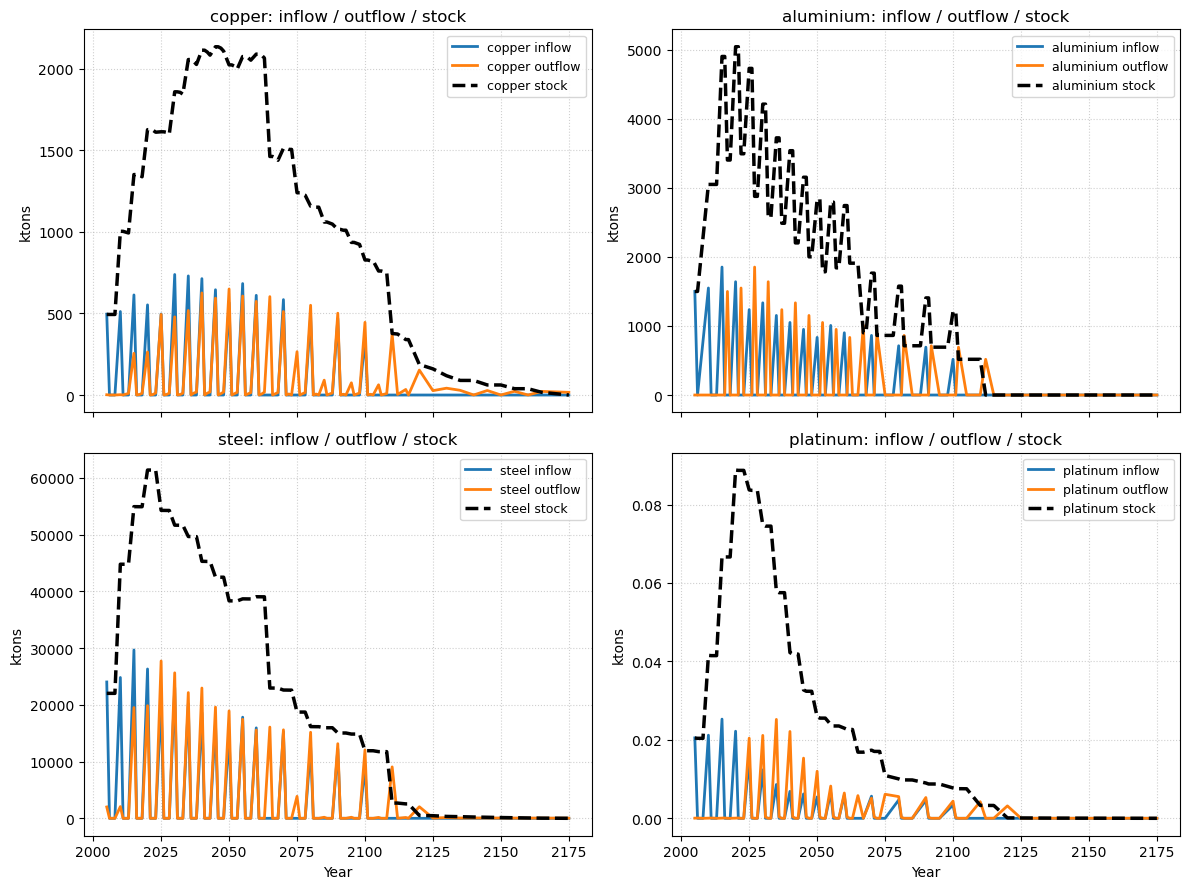

In [47]:
methods_map = {
    "copper": copper_method,
    "aluminium": aluminium_method,
    "steel": steel_method,
    "platinum": platinum_method,
}

tech_fus = [
    ({icev.id: 1.0},   "ICEV"),
    ({bev.id: 1.0},    "BEV"),
    ({cng.id: 1.0},    "CNG"),
    ({hybrid.id: 1.0}, "PHEV"),
    ({fcev.id: 1.0},   "FCEV"),
]


sales_tech = (
    wide.reset_index()
        .melt(id_vars="Year", var_name="tech_raw", value_name="vehicles")
        .assign(
            tech=lambda d: d["tech_raw"].replace({"CNG": "Gases", "PHEV": "Hybrid"})
        )[["Year", "tech", "vehicles"]]
)

per_vehicle = {metal: {} for metal in methods_map}

for metal, method in methods_map.items():
    print(f"Calculating LCA coefficients for {metal}")
    # init LCA once per metal
    first_fu, first_tech = tech_fus[0]
    LCA = EdgeLCIA(demand=first_fu, method=method)
    LCA.lci()
    LCA.apply_strategies()
    LCA.evaluate_cfs()
    LCA.lcia()

    # capture first tech
    df = LCA.generate_cf_table().copy()
    if "consumer cpc code" not in df.columns and "consumer cpc" in df.columns:
        df["consumer cpc code"] = df["consumer cpc"].str.extract(r"^\s*(\d+)")
    if "consumer cpc code" in df.columns:
        df["lifetime"] = df["consumer cpc code"].map(code_to_lifetime)
    df.loc[df["consumer name"] == "Glider lightweighting", "lifetime"] = 12
    per_vehicle[metal][first_tech] = df[["amount", "lifetime"]].copy()

    # redo for others
    for fu, tech in tech_fus[1:]:
        LCA.redo_lcia(fu)
        df = LCA.generate_cf_table().copy()
        if "consumer cpc code" not in df.columns and "consumer cpc" in df.columns:
            df["consumer cpc code"] = df["consumer cpc"].str.extract(r"^\s*(\d+)")
        if "consumer cpc code" in df.columns:
            df["lifetime"] = df["consumer cpc code"].map(code_to_lifetime)
        df.loc[df["consumer name"] == "Glider lightweighting", "lifetime"] = 12
        per_vehicle[metal][tech] = df[["amount", "lifetime"]].copy()


flows_by_metal = {}

for metal, perveh_by_tech in per_vehicle.items():
    out_frames = []
    for tech, exch in perveh_by_tech.items():
        if exch.empty:
            continue
        s = sales_tech[sales_tech["tech"] == tech]
        if s.empty:
            continue

        # cross-join exchanges with yearly sales for this tech
        tmp = exch.copy()
        tmp["key"] = 1
        s_ = s.copy()
        s_["key"] = 1
        merged = tmp.merge(s_, on="key", how="left").drop(columns="key")

        merged["total_amount"] = merged["amount"] * merged["vehicles"]
        out_frames.append(merged)

    if not out_frames:
        flows_by_metal[metal] = pd.DataFrame(columns=["Year", "sales", "return", "stock_in_use"])
        continue

    df_yearly = pd.concat(out_frames, ignore_index=True)

    # ensure proper types
    df_yearly["Year"] = df_yearly["Year"].astype(int)
    df_yearly["lifetime"] = df_yearly["lifetime"].fillna(0).astype(int)

    # inflow/outflow/stock
    df_yearly["return_year"] = df_yearly["Year"] + df_yearly["lifetime"]

    returns = (
        df_yearly.groupby("return_year", as_index=False)["total_amount"]
        .sum().rename(columns={"return_year": "Year", "total_amount": "return"})
    )
    sales = (
        df_yearly.groupby("Year", as_index=False)["total_amount"]
        .sum().rename(columns={"total_amount": "sales"})
    )

    stock_flow = pd.merge(sales, returns, on="Year", how="outer").fillna(0.0)
    stock_flow = stock_flow.sort_values("Year")
    stock_flow["stock_in_use"] = stock_flow["sales"].cumsum() - stock_flow["return"].cumsum()

    # scale (assumes amounts are kg → ktons)
    stock_flow.loc[:, "sales":] = stock_flow.loc[:, "sales":] / 1e6

    flows_by_metal[metal] = stock_flow

n = max(1, len(methods_map))
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 9), sharex=True)
axes = np.array(axes).reshape(rows, cols)

metal_list = list(methods_map.keys())
for idx in range(rows * cols):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    if idx >= n:
        ax.axis("off")
        continue

    metal = metal_list[idx]
    sf = flows_by_metal[metal]

    if sf.empty:
        ax.text(0.5, 0.5, f"No data for {metal}", ha="center", va="center")
        ax.set_axis_off()
        continue

    ax.plot(sf["Year"], sf["sales"],        label=f"{metal} inflow",  linewidth=2)
    ax.plot(sf["Year"], sf["return"],       label=f"{metal} outflow", linewidth=2)
    ax.plot(sf["Year"], sf["stock_in_use"], label=f"{metal} stock",   linewidth=2.5, linestyle="--", color="black")

    ax.set_title(f"{metal}: inflow / outflow / stock")
    ax.set_ylabel("ktons")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(fontsize=9, loc="upper right")

for ax in axes[-1]:
    ax.set_xlabel("Year")

fig.tight_layout()
plt.show()


In [48]:
# check values for platinum
df.sort_values(by="impact", ascending=False)

,supplier name,supplier reference product,supplier location,supplier cpc,supplier isic rev.4 ecoinvent,consumer name,consumer reference product,consumer location,consumer cpc,consumer ecospold01categories,consumer isic rev.4 ecoinvent,amount,CF,impact,consumer cpc code,lifetime
53,market for platinum,platinum,GLO,"41330: Platinum, unwrought or in semi-manufact...",2420:Manufacture of basic precious and other n...,"internal combustion engine production, passeng...","internal combustion engine, passenger car",GLO,4312: Internal combustion engines of a kind us...,None,2910:Manufacture of motor vehicles,6.975293e-04,1.0,6.975293e-04,4312,20.0
96,market for platinum,platinum,GLO,"41330: Platinum, unwrought or in semi-manufact...",2420:Manufacture of basic precious and other n...,"petrol production, unleaded, petroleum refiner...","petrol, unleaded",Europe without Switzerland,33311: Motor gasoline,None,1920:Manufacture of refined petroleum products,1.217510e-05,1.0,1.217510e-05,33311,1.0
9,market for platinum,platinum,GLO,"41330: Platinum, unwrought or in semi-manufact...",2420:Manufacture of basic precious and other n...,"diesel production, petroleum refinery operation",diesel,RoW,33360: Gas oil,None,1920:Manufacture of refined petroleum products,8.221589e-06,1.0,8.221589e-06,33360,1.0
112,market for platinum,platinum,GLO,"41330: Platinum, unwrought or in semi-manufact...",2420:Manufacture of basic precious and other n...,"diesel production, low-sulfur, petroleum refin...","diesel, low-sulfur",RoW,33360: Gas oil,None,1920:Manufacture of refined petroleum products,7.992940e-06,1.0,7.992940e-06,33360,1.0
65,market for platinum,platinum,GLO,"41330: Platinum, unwrought or in semi-manufact...",2420:Manufacture of basic precious and other n...,"naphtha production, petroleum refinery operation",naphtha,RoW,33330: Naphtha,None,1920:Manufacture of refined petroleum products,3.235139e-06,1.0,3.235139e-06,33330,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,market for platinum,platinum,GLO,"41330: Platinum, unwrought or in semi-manufact...",2420:Manufacture of basic precious and other n...,"white spirit production, petroleum refinery op...",white spirit,ZA,33350: White spirit and special boiling point ...,None,1920:Manufacture of refined petroleum products,1.649393e-14,1.0,1.649393e-14,33350,1.0
56,market for platinum,platinum,GLO,"41330: Platinum, unwrought or in semi-manufact...",2420:Manufacture of basic precious and other n...,"hydrogen production, gaseous, petroleum refine...","hydrogen, gaseous, low pressure",ZA,"34210: Hydrogen, nitrogen, oxygen, carbon diox...",None,1920:Manufacture of refined petroleum products,4.916841e-15,1.0,4.916841e-15,34210,1.0
13,market for platinum,platinum,GLO,"41330: Platinum, unwrought or in semi-manufact...",2420:Manufacture of basic precious and other n...,"white spirit production, petroleum refinery op...",white spirit,PE,33350: White spirit and special boiling point ...,None,1920:Manufacture of refined petroleum products,3.857450e-15,1.0,3.857450e-15,33350,1.0
90,market for platinum,platinum,GLO,"41330: Platinum, unwrought or in semi-manufact...",2420:Manufacture of basic precious and other n...,"hydrogen production, gaseous, petroleum refine...","hydrogen, gaseous, low pressure",PE,"34210: Hydrogen, nitrogen, oxygen, carbon diox...",None,1920:Manufacture of refined petroleum products,3.443495e-15,1.0,3.443495e-15,34210,1.0
